In [1]:
print('here..')

here..


In [1]:
# !pip install google-api-python-client pandas vaderSentiment textblob python-dotenv spacy nltk wordcloud scikit-learn

In [ ]:
# !pip install spacy
# from spacy.cli import download
#
# download("en_core_web_sm")

In [2]:
import csv
import os
import re
import string
import time
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import spacy
from dotenv import load_dotenv
from googleapiclient.discovery import build
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

load_dotenv()

True

In [2]:
df_new = pd.read_csv('youtube_data.csv')
df_new.shape

(16342, 11)

In [30]:
class YouTubeDataFetcher:
    def __init__(self):
        """
        Initializes the YouTubeDataFetcher object with the API key and output file.
        """
        self.api_keys = [
            os.getenv('YOUTUBE_API_KEY_1'),
            os.getenv('YOUTUBE_API_KEY_2'),
            os.getenv('YOUTUBE_API_KEY_3'),
            os.getenv('YOUTUBE_API_KEY_4'),
            os.getenv('YOUTUBE_API_KEY_5'),
        ]
        self.output_file = 'youtube_data.csv'
        self.current_api_key_index = 0  # Keeps track of the current API key index
        self.youtube = self.get_youtube_client(self.api_keys[self.current_api_key_index])
        self.headers = ["video_id", "title", "description", "view_count", "like_count",
                        "dislike_count", "comment_count", "duration", "favorite_count", "comments", "sentiment_score"]

        # Load existing processed video IDs
        self.processed_video_ids = self.load_processed_video_ids()

        # Initialize CSV file (with headers) if it doesn't exist
        self.initialize_csv()

    @staticmethod
    def get_youtube_client(api_key):
        """
        Initializes and returns the YouTube API client with the given API key.
        """
        return build("youtube", "v3", developerKey=api_key)

    def load_processed_video_ids(self):
        """
        Loads the list of processed video IDs from the output CSV file.
        Returns a set of video IDs that have already been processed.
        """
        processed_ids = set()
        try:
            df = pd.read_csv(self.output_file)
            processed_ids = set(df['video_id'].values)
        except FileNotFoundError:
            pass  # If the file doesn't exist yet, just return an empty set
        return processed_ids

    def initialize_csv(self):
        """
        Initializes the CSV file if it doesn't exist, and writes the header.
        """
        if not os.path.exists(self.output_file) or os.stat(self.output_file).st_size == 0:
            # Create CSV and write the header if the file doesn't exist or is empty
            try:
                with open(self.output_file, mode='w', newline='', encoding='utf-8') as file:
                    writer = csv.DictWriter(file, fieldnames=self.headers)
                    writer.writeheader()
            except Exception as e:
                print(f"Error creating file: {str(e)}")

    def fetch_video_data(self, video_id):
        """
        Fetches the video details (views, likes, etc.) and comments for the given video_id.
        """
        attempt = 0
        max_attempts = len(self.api_keys) * 2

        while attempt < max_attempts:
            api_key = self.api_keys[self.current_api_key_index % len(self.api_keys)]  # Rotate API keys continuously
            self.youtube = self.get_youtube_client(api_key)  # Re-initialize the client on each key switch
            try:
                # Get the video details (view count, like count, etc.)
                video_response = self.youtube.videos().list(
                    part="snippet,statistics,contentDetails",
                    id=video_id
                ).execute()

                if not video_response["items"]:
                    raise Exception(f"No video found for ID: {video_id}")

                video_info = video_response["items"][0]
                title = video_info["snippet"]["title"]
                description = video_info["snippet"].get("description", "No description")
                view_count = int(video_info["statistics"].get("viewCount", 0))
                like_count = int(video_info["statistics"].get("likeCount", 0))
                dislike_count = int(video_info["statistics"].get("dislikeCount", 0))
                comment_count = int(video_info["statistics"].get("commentCount", 0))
                duration = video_info["contentDetails"]["duration"]
                favorite_count = int(video_info["statistics"].get("favoriteCount", 0))

                # Fetching comments (max 100 comments)
                comments = []
                comment_response = self.youtube.commentThreads().list(
                    part="snippet",
                    videoId=video_id,
                    maxResults=100
                ).execute()

                for item in comment_response["items"]:
                    comment_text = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
                    comments.append(comment_text)

                return {
                    "video_id": video_id,
                    "title": title,
                    "description": description,
                    "view_count": view_count,
                    "like_count": like_count,
                    "dislike_count": dislike_count,
                    "comment_count": comment_count,
                    "duration": duration,
                    "favorite_count": favorite_count,
                    "comments": comments
                }

            except Exception as e:
                if "quotaExceeded" in str(e):
                    print(f"API key {api_key} quota exceeded. Switching to next API key.")
                    attempt += 1
                    self.current_api_key_index += 1
                    continue  # Try with the next API key
                else:
                    print(f"Error fetching data for {video_id}: {str(e)}")
                    return None

        print("All API keys exhausted, cannot fetch data.")
        return None

    @staticmethod
    def analyze_sentiment(comments):
        """
        Analyzes the sentiment of the provided comments using VADER Sentiment Analysis.
        Returns a sentiment score.
        """
        analyzer = SentimentIntensityAnalyzer()
        sentiment_score = 0
        num_comments = len(comments)

        for comment in comments:
            sentiment = analyzer.polarity_scores(comment)
            sentiment_score += sentiment['compound']

        # Calculate the average sentiment score
        if num_comments > 0:
            sentiment_score /= num_comments
        return sentiment_score

    def save_to_csv(self, video_data):
        """
        Saves the fetched video data into the CSV file, appending to it.
        """
        try:
            with open(self.output_file, mode='a', newline='', encoding='utf-8') as file:
                writer = csv.DictWriter(file, fieldnames=self.headers)
                writer.writerow({
                    "video_id": video_data["video_id"],
                    "title": video_data["title"],
                    "description": video_data["description"],
                    "view_count": video_data["view_count"],
                    "like_count": video_data["like_count"],
                    "dislike_count": video_data["dislike_count"],
                    "comment_count": video_data["comment_count"],
                    "duration": video_data["duration"],
                    "favorite_count": video_data["favorite_count"],
                    "comments": " | ".join(video_data["comments"]),
                    "sentiment_score": video_data["sentiment_score"]
                })
        except Exception as e:
            print(f"Error saving data for {video_data['video_id']}: {str(e)}")

    def check_if_data_available(self) -> bool:
        """
        Checks if the data is available in the output CSV file.
        """
        try:
            df = pd.read_csv(self.output_file)
            return not df.empty
        except FileNotFoundError:
            return False

    def fetch_and_process_data(self, df):
        """
        Fetches and processes data for each video in the provided DataFrame.
        Saves the results into a CSV file.
        """

        if self.check_if_data_available():
            print('Data pulled already and available')
            return

        for index, row in df.iterrows():
            video_id = row['youtubeId']

            # Skip the video if it's already processed
            if video_id in self.processed_video_ids:
                print(f"{index}. Skipping already processed video: {video_id}")
                continue

            print(f"{index}. Processing video: {video_id}")

            if video_data := self.fetch_video_data(video_id):
                # Analyze sentiment of the comments
                sentiment_score = self.analyze_sentiment(video_data["comments"])
                video_data["sentiment_score"] = sentiment_score

                # Save the data to the CSV file
                self.save_to_csv(video_data)

            # Sleep to avoid rate-limiting
            time.sleep(3)

        print(f"Data fetching and saving complete. All data saved in {self.output_file}.")

    @staticmethod
    def generate_wordcloud(df):
        """
        Generates a word cloud from the comments of all videos.
        """
        all_comments = " ".join(df["comments"].dropna())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

    @staticmethod
    def generate_graphs(df):
        """
        Generates various plots for video statistics using Plotly Express.
        """
        # Top 10 most viewed videos
        top_10 = df.nlargest(10, "view_count")
        fig = px.bar(top_10, x='title', y='view_count', title='Top 10 Most Viewed Videos')
        fig.show()

        # Bottom 10 least viewed videos
        bottom_10 = df.nsmallest(10, "view_count")
        fig = px.bar(bottom_10, x='title', y='view_count', title='Bottom 10 Least Viewed Videos')
        fig.show()

        # Most liked video
        most_liked = df.loc[df['like_count'].idxmax()]
        fig = px.bar(x=[most_liked['title']], y=[most_liked['like_count']], title='Most Liked Video')
        fig.show()

        # Least liked video
        least_liked = df.loc[df['like_count'].idxmin()]
        fig = px.bar(x=[least_liked['title']], y=[least_liked['like_count']], title='Least Liked Video')
        fig.show()

        # Video with the highest duration
        highest_duration = df.loc[df['duration'].idxmax()]
        fig = px.bar(x=[highest_duration['title']], y=[highest_duration['duration']],
                     title='Video with Highest Duration')
        fig.show()



In [52]:
"""
This Clas handles the text in the dataset
- it's used to a manipulate textual data
"""


class TextWrangler:
    def __init__(self):
        self.count = CountVectorizer()
        self.tf_idf_ = TfidfVectorizer()
        self.spacy_en = spacy.load('en_core_web_sm')
        # Download stopwords if not already downloaded
        try:
            self.stop_words = set(stopwords.words('english'))
        except LookupError:
            import nltk
            nltk.download('stopwords')
            nltk.download('punkt')
            self.stop_words = set(stopwords.words('english'))

    @staticmethod
    def remove_digit(text: str) -> str:
        """
        This method removes digit from a text
        """
        return re.sub(r'\d+', '', text)

    @staticmethod
    def remove_punctuations(text: str) -> str:
        """
        This method removes punctuation from a text
        """
        return text.translate(str.maketrans('', '', string.punctuation))

    @staticmethod
    def clean_text(text: str) -> str:
        """
        Clean the text and remove punctuations.
        """
        text = re.sub('<.*?>', '', text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        return text.lower()                 

    @staticmethod
    def remove_excessive_punctuation(text) -> str:
        """
        Replace multiple punctuation marks with a single one
        """
        text = re.sub(r'([!.,?;])\1+', r'\1', text)
        return text
           
    @staticmethod
    def remove_urls_emails_mentions(text) -> str:
        """
        Remove URLs (http, https, www)
        """
        text = re.sub(r'http[s]?://\S+', '', text)
        text = re.sub(r'www\.\S+', '', text)
    
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
    
        # Remove mentions (@username)
        text = re.sub(r'@\w+', '', text)
        
        return text

    @staticmethod
    def remove_non_informative_symbols(text) -> str:
        """
        Remove everything except alphabets, numbers, and spaces
        """
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)

    @staticmethod
    def word_lengthening(text: str) -> str:
        """
        Fix a word by reducing any character repeated three or more times
        to just two instances of that character.
        """
        return re.sub(r'(.)\1{2,}', r'\1\1', text.strip())

    @staticmethod
    def tokenize(text: str) -> List[str]:
        """
        Tokenize the given text into words.
        """
        return word_tokenize(text)

    def remove_stopwords(self, text: str) -> str:
        """
        Remove stop words from a given text.
        """
        filtered_text = [word for word in self.tokenize(text) if word.lower() not in self.stop_words]
        return ' '.join(filtered_text)

    def lemmatizer(self, text: str) -> str:
        """
        This method lemmatizes a text by using the spaCy libary
        """
        text = self.spacy_en(text)

        # get the lemmatized token from text
        lemmatized_tokens = [token.lemma_ for token in text]

        # use lemmatized token to form a sentence
        return ' '.join(lemmatized_tokens)

    @staticmethod
    def plot_word_cloud(data, title):
        """
        Generate a graphical representation of the words in the text
        """
        wordcloud = WordCloud(width=900, height=600, max_words=100, background_color='white').generate(data)

        plt.figure(figsize=(20, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontsize=15)
        plt.axis('off')
        plt.show()
        return


In [32]:
# Load the CSV containing the video data
df = pd.read_csv('vdoLinks.csv')

In [33]:
df.head()

,youtubeId,movieId,title
0,K26_sDKnvMU,1,Toy Story (1995)
1,3LPANjHlPxo,2,Jumanji (1995)
2,rEnOoWs3FuA,3,Grumpier Old Men (1995)
3,j9xml1CxgXI,4,Waiting to Exhale (1995)
4,ltwvKLnj1B4,5,Father of the Bride Part II (1995)


In [34]:
df.shape

(25623, 3)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25623 entries, 0 to 25622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   youtubeId  25623 non-null  object
 1   movieId    25623 non-null  int64 
 2   title      25623 non-null  object
dtypes: int64(1), object(2)
memory usage: 600.7+ KB


In [36]:
df.columns

Index(['youtubeId', 'movieId', 'title'], dtype='object')

In [37]:
# Create an instance of YouTubeDataFetcher and process the data
fetcher = YouTubeDataFetcher()
fetcher.fetch_and_process_data(df)

Data pulled already and available


In [38]:
# Load the new CSV containing the downloaded video data
df = pd.read_csv('./youtube_data.csv')

In [39]:
df.head(2)

,video_id,title,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments,sentiment_score
0,rEnOoWs3FuA,Grumpier Old Men - Trailer,"The more things change, the more they stay the...",231725,220,0,13,PT1M52S,0,Buena película de comedia romántica | <a href=...,0.192850
1,2GfZl4kuVNI,Heat Trailer HD (1995),"Director: Michael Mann.\nCast: Al Pacino, Robe...",1539012,8462,0,681,PT2M28S,0,er muss euch drauf hinweisen ! | Might be one ...,0.336871


In [40]:
df.shape

(16342, 11)

here we can see that the rows are less than 25623 and this is due to the following factors noticed while pulling the data. The factors includes:

1.⁠ ⁠not valid id (id does not exist)
2.⁠ ⁠⁠comments disabled
3.⁠ ⁠⁠the video is not listed again (so the Id might exist but it’s not listed for people to get the data)
4.⁠ ⁠⁠the video is made private (this is different from not listed since it’s listed but access is limited to some account)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16342 entries, 0 to 16341
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   video_id         16342 non-null  object 
 1   title            16342 non-null  object 
 2   description      15935 non-null  object 
 3   view_count       16342 non-null  int64  
 4   like_count       16342 non-null  int64  
 5   dislike_count    16342 non-null  int64  
 6   comment_count    16342 non-null  int64  
 7   duration         16342 non-null  object 
 8   favorite_count   16342 non-null  int64  
 9   comments         15331 non-null  object 
 10  sentiment_score  16342 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 1.4+ MB


In [42]:
df.columns

Index(['video_id', 'title', 'description', 'view_count', 'like_count',
       'dislike_count', 'comment_count', 'duration', 'favorite_count',
       'comments', 'sentiment_score'],
      dtype='object')

In [43]:
df.describe()

,view_count,like_count,dislike_count,comment_count,favorite_count,sentiment_score
count,1.634200e+04,1.634200e+04,16342.0,16342.000000,16342.0,16342.000000
mean,7.993765e+05,3.204288e+03,0.0,260.570922,0.0,0.195220
std,2.001056e+07,1.096668e+05,0.0,2642.896845,0.0,0.205736
min,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,-0.998800
25%,2.410275e+04,5.700000e+01,0.0,6.000000,0.0,0.048291
50%,8.369200e+04,1.920000e+02,0.0,23.000000,0.0,0.188992
75%,3.180360e+05,7.220000e+02,0.0,92.000000,0.0,0.312450
max,2.485791e+09,1.354636e+07,0.0,264407.000000,0.0,0.990800


In [44]:
df['comments'].head(5)

0    Buena película de comedia romántica | <a href=...
1    er muss euch drauf hinweisen ! | Might be one ...
2    Oxe. No trailer dá logo o spoiler máximo.😂 | B...
3    Why does this have the Little Women (1994) sco...
4    The last line in the trailer with Dracula was ...
Name: comments, dtype: object

Data Cleaning

In [46]:
df.isna().sum()

video_id           0
title              0
description        0
view_count         0
like_count         0
dislike_count      0
comment_count      0
duration           0
favorite_count     0
comments           0
sentiment_score    0
dtype: int64

there're no missing values as the data are carefully curated.

In [53]:
text_wrangler = TextWrangler()

Since we're using Vader sentiment analyzer we can directly apply it on the 'comments' column.

the only 3 things we can only manage is removing:
1. the excessive punctuation. eg good!!!
2. URLs, emails, or mentions (@username), 
3. Non-informative symbols

In [57]:
df['cleanedComments'] = (df['comments']
                         .apply(text_wrangler.word_lengthening)
                         .apply(text_wrangler.remove_excessive_punctuation)
                         .apply(text_wrangler.remove_urls_emails_mentions)
                         .apply(text_wrangler.remove_non_informative_symbols))



In [58]:
df['comments'].head()

0    Buena película de comedia romántica | <a href=...
1    er muss euch drauf hinweisen ! | Might be one ...
2    Oxe. No trailer dá logo o spoiler máximo.😂 | B...
3    Why does this have the Little Women (1994) sco...
4    The last line in the trailer with Dracula was ...
Name: comments, dtype: object

In [65]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import nltk

class GenerateGrams:
    def __init__(self):
        # Load stop words from NLTK
        self.stop_words = set(stopwords.words('english'))

    def remove_stopwords(self, tokens):
        """Remove stopwords from the tokens."""
        return [token for token in tokens if token.lower() not in self.stop_words]

    @staticmethod
    def generate_ngrams(tokens, n):
        """Generate n-grams from the tokens."""
        ngrams_list = list(ngrams(tokens, n))
        return [" ".join(_gram) for _gram in ngrams_list]

    def generate_grams(self, col_df, size):
        """Generate n-grams and return the most common ones."""
        ngrams_list = []
        for _data in col_df:
            tokens = _data.split()
            
            # Remove stopwords from the tokens
            tokens = self.remove_stopwords(tokens)
            
            if len(tokens) <= size:
                continue
            ngrams_list.extend(self.generate_ngrams(tokens, size))

        # Count the ngrams and return the most common ones
        cnt_ngram = Counter(ngrams_list)
        most_common_ngrams = cnt_ngram.most_common(15)

        temp_df = pd.DataFrame(most_common_ngrams, columns=['words', 'count'])
        temp_df = temp_df.sort_values(by='count', ascending=False)

        return temp_df

    def plot_n_grams(self, col_df):
        """Plot Unigrams, Bigrams, and Trigrams."""
        unigrams = self.generate_grams(col_df, 1)
        bigrams = self.generate_grams(col_df, 2)
        trigrams = self.generate_grams(col_df, 3)

        # Set plot figure size
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 25))  # 3 rows, 1 column

        self.plot_gram(ax1, unigrams, 'Unigrams')
        self.plot_gram(ax2, bigrams, 'Bigrams')
        self.plot_gram(ax3, trigrams, 'Trigrams')
        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()

    def plot_gram(self, ax, ngram_df, ngram_type):
        """Plot the n-gram bar chart."""
        ax.barh(np.arange(len(ngram_df['words'])), ngram_df['count'], align='center', alpha=0.5)
        ax.set_title(ngram_type)
        ax.set_yticks(np.arange(len(ngram_df['words'])))
        ax.set_yticklabels(ngram_df['words'])
        ax.set_xlabel('Count')


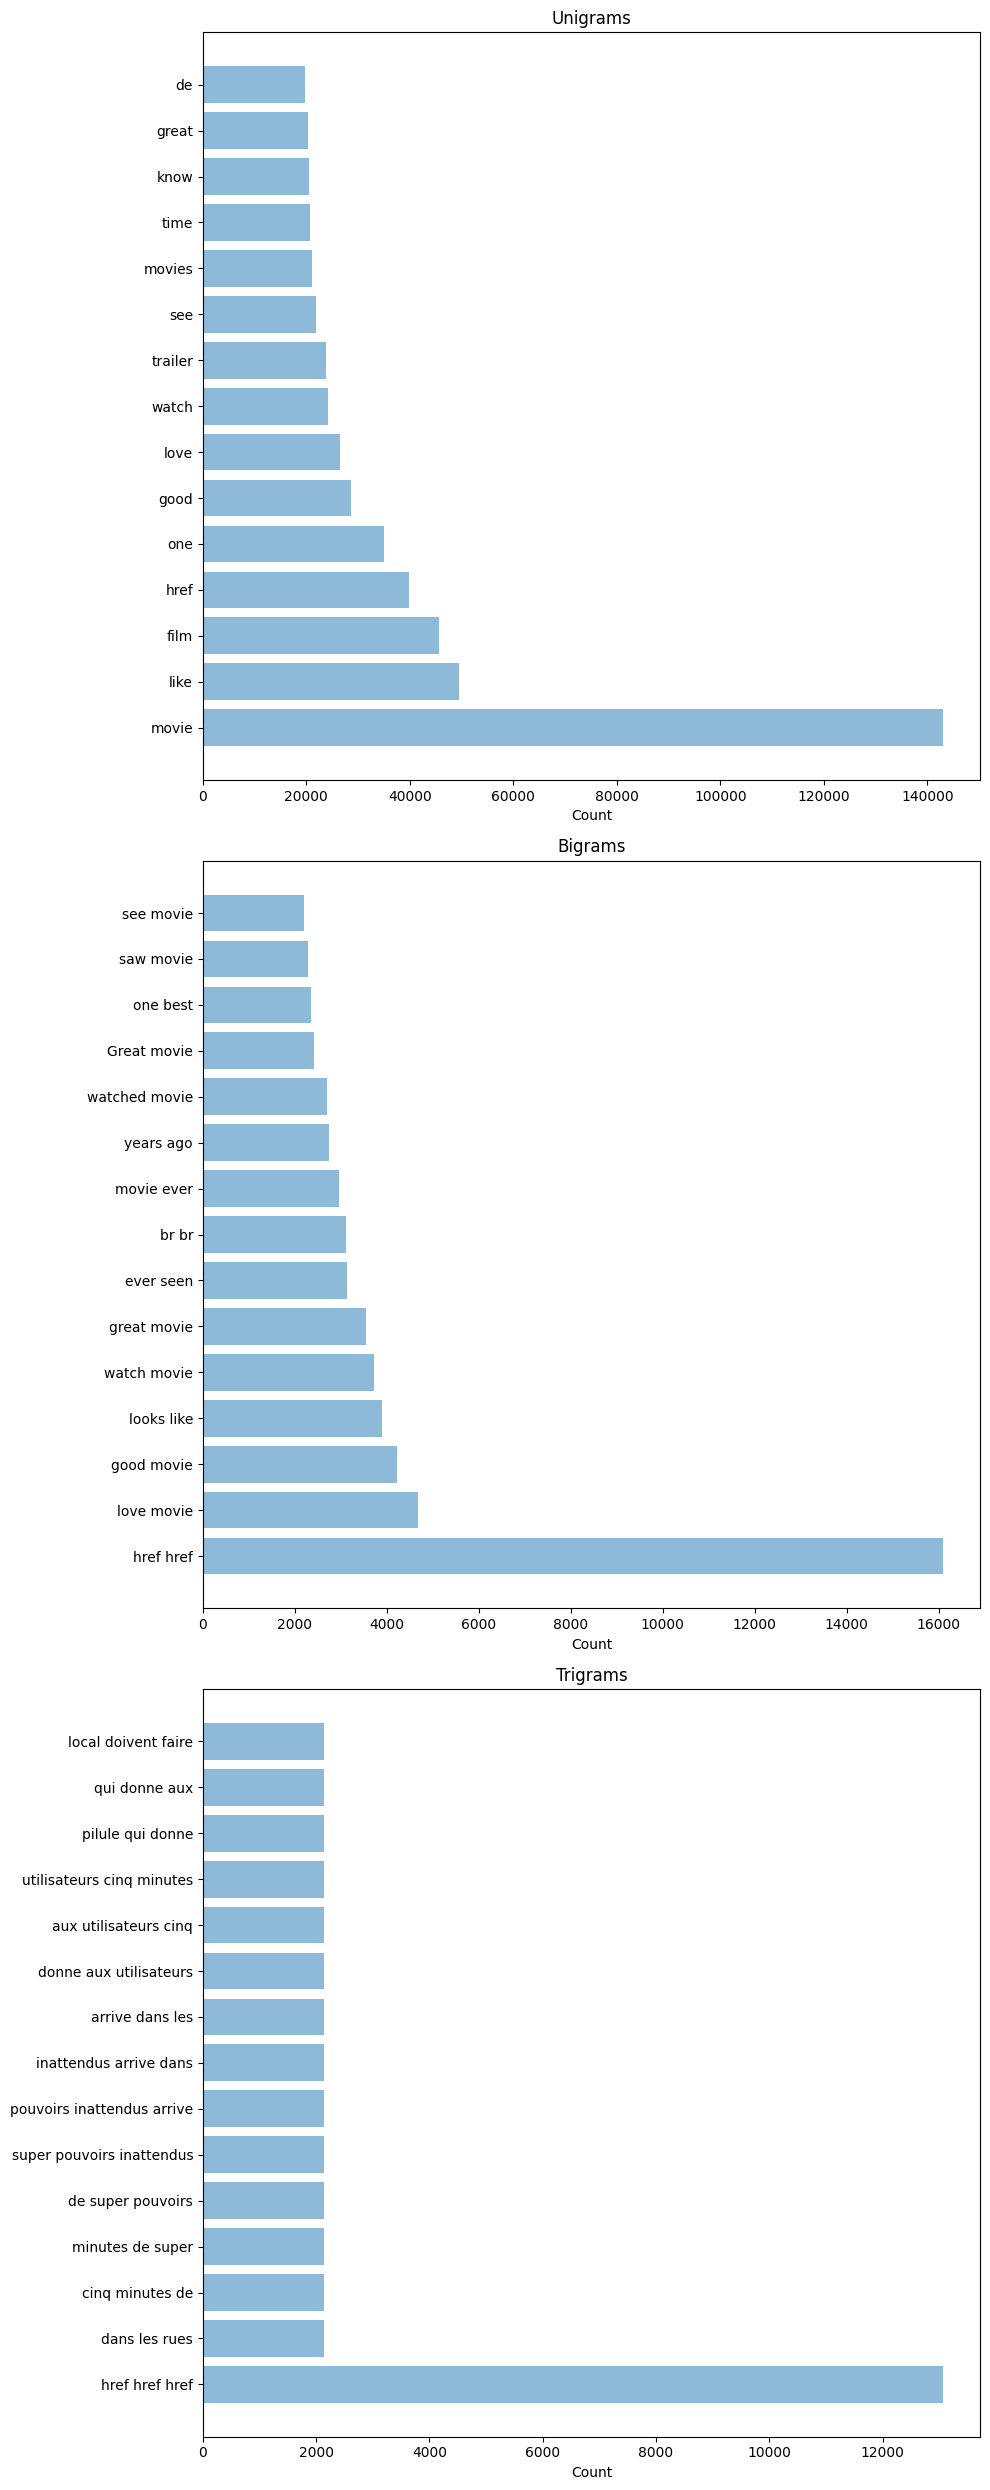

In [66]:
# Initialize the class
gram_generator = GenerateGrams()

# Generate n-grams and plot them
gram_generator.plot_n_grams(df['cleanedComments'])

In [64]:
"""
TextSentimentAnalysis Class provides the sentiment for the input text in its raw form
"""


class TextSentimentAnalysis:
    def __init__(self) -> None:
        """
        Initialize vader sentiment analyzer
        """
        self.sid = SentimentIntensityAnalyzer()

    def get_sentiment_via_vader(self, text: str) -> float:
        """
        return the compound score
        """
        # Using compound score as a single sentiment score
        return self.sid.polarity_scores(text)['compound']

In [ ]:
text_sentiment_analysis = TextSentimentAnalysis()

In [ ]:
df['commentsSentiment'] = df['comments'].apply(text_sentiment_analysis.get_sentiment_via_vader)

In [ ]:
df['cleanedCommentsSentiment'] = df['cleanedComments'].apply(text_sentiment_analysis.get_sentiment_via_vader)

In [ ]:
df.head()

In [ ]:
# generate the word cloud and plots
fetcher.generate_wordcloud(df)

In [ ]:
fetcher.generate_graphs(df)